## Balancing Algorithm 
This notebook is/was used for designing and implementing the algorithm (on abstract trees). 
Any code that has been completed has been moved to regular .py files for reuse in other scripts and notebooks

In [1]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/notebooks


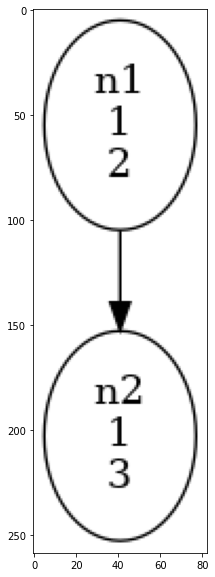

In [3]:
%autoreload 2
import os
import networkx as nx
from rwtools.nemesis.graph.nemesis_node import NemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

def to_png(graph, name="temp"):
    out_file = os.path.abspath(f"./{name}.dot")
    nx.drawing.nx_agraph.write_dot(graph, out_file)
    cmd = f"dot -Tpng {out_file} -o {name}.png"
    os.system(cmd)
    img = mpimg.imread(f"{name}.png")
    plt.figure(figsize = (10,10))
    plt.imshow(img)

    
G = nx.DiGraph()
n1 = NemesisNode([1, 2], "n1")
n2 = NemesisNode([1, 3], "n2")

G.add_node(n1)
G.add_node(n2)

G.add_edge(n1, n2)

to_png(G)


## Step 1 
First little test, take a simple graph (single root with two children) and balance the latencies of the children directly 

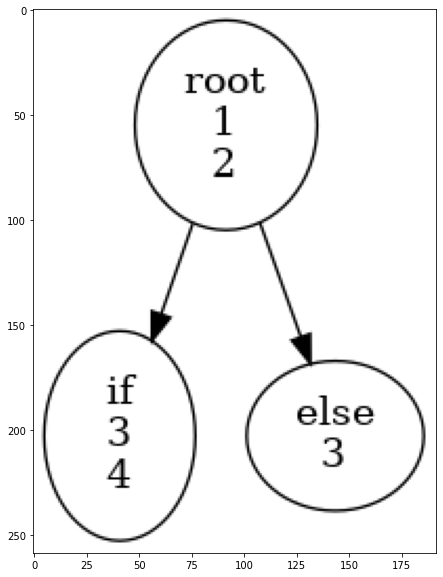

In [6]:
%autoreload 2
from rwtools.nemesis.graph.nemesis_node import NemesisNode

root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")

graph = nx.DiGraph()
graph.add_nodes_from([root, ifbranch, elsebranch])
graph.add_edges_from([(root, ifbranch), (root, elsebranch)])


to_png(graph, "test1_original")


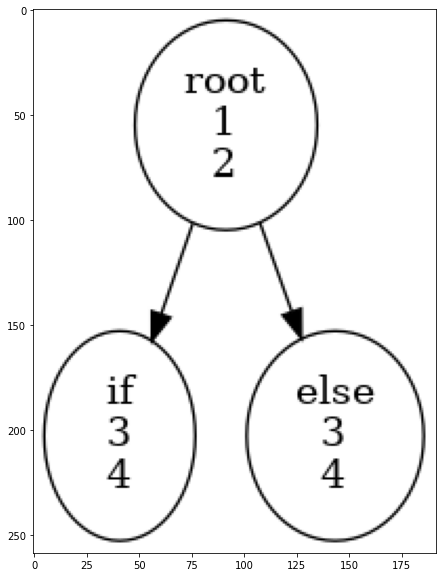

In [7]:
%autoreload 2
from rwtools.nemesis.graph.nemesis_node import NemesisNode
from rwtools.nemesis.graph.balance import balance_node_latencies


root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")


graph = nx.DiGraph()
graph.add_nodes_from([root, ifbranch, elsebranch])
graph.add_edges_from([(root, ifbranch), (root, elsebranch)])

balance_node_latencies(graph, ifbranch, elsebranch)

to_png(graph, "test1_balanced")


## Step 2
We want to 'balance' a node, i.e. balance the latencies of its children. 
Introduce a function that gets a nodes children and balances them

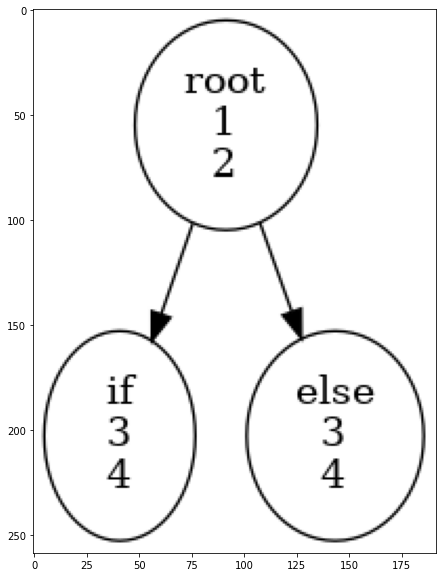

In [8]:
from rwtools.nemesis.graph.balance import * 

root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")

G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch])
G.add_edges_from([(root, ifbranch), (root, elsebranch)])

balance_branching_point(G, root)

to_png(G, "test1_balanced")

## Step 3 
Now we want to recursively balance the nodes
 
Two problems to approach 
1) we need to balance at every level below the target node -- each descendent has to be balanced 
2) balancing has to occur across levels, we also don't neccesarily know which of the successors should be balanced first 



Possible approach 1 - first insert empty nodes, and then balance level per level. This would mean you are balancing several nodes at once instead of just two 

Possible approach 2 - Do a binary (pairwise) balancing where you work with pairs of nodes. You would have to 
figure out a good order here first 

## Approach 2
Refering to example below --  
You first balance nodes 'a' and 'b'. Once these are balanced you have a balanced subtree with root 'else'  
then you can balance node 'if' with **tree** else   
This approach works if you define an operation for balancing a node with a tree 

### Balancing a node and a tree (or balancing as a more general operation) 




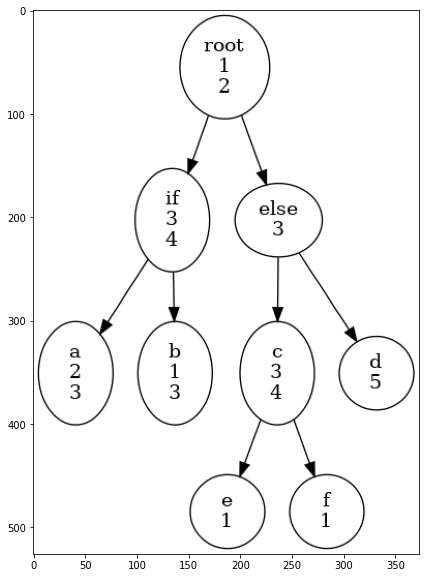

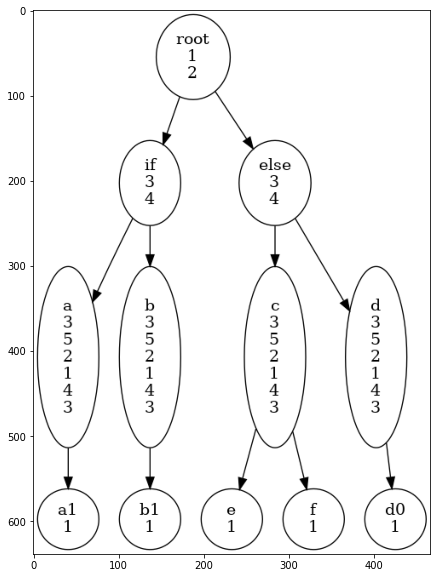

In [9]:
from itertools import zip_longest
import copy 
        
root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")

a = NemesisNode([2,3], "a")
b = NemesisNode([1,3], "b")

c = NemesisNode([3, 4], "c")
d = NemesisNode([5],  "d")

e = NemesisNode([1], "e")
f = NemesisNode([1], "f")

G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch, a, b, c, d, e, f])
G.add_edges_from([(root, ifbranch), (root, elsebranch), (ifbranch, a), (ifbranch, b), (elsebranch,c), 
                 (elsebranch, d), (c, e), (c, f)])

to_png(G, "test3_pre_balance")
balance_branching_point(G,  root)
to_png(G, "test3")


## Balancing a node and a (balanced) tree 

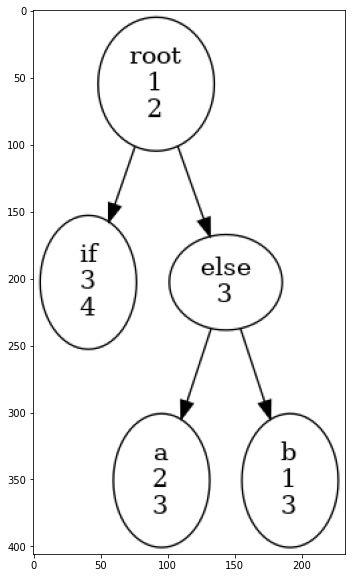

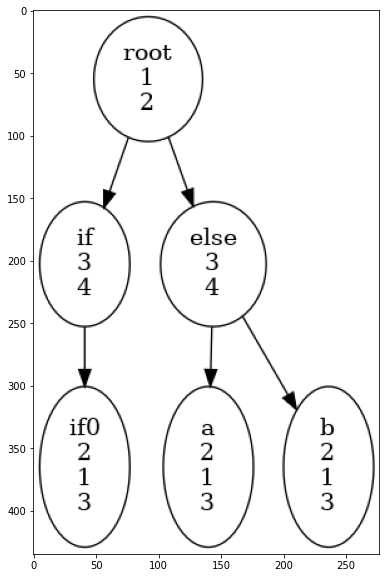

In [16]:
        
root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")

a = NemesisNode([2,3], "a")
b = NemesisNode([1,3], "b")

G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch, a, b])
G.add_edges_from([(root, ifbranch), (root, elsebranch), (elsebranch, a), (elsebranch, b)])
to_png(G, "test2_pre_balance")
balance_branching_point(G,  root)
to_png(G, "test2")

## Special cases 
### 1. Branches that rejoin 

See example below
It achieves the goal in that after a n steps (with n smaller than the max number of steps in the original) 
the latencies are always identical. 
However, it adds nodes to the left branch, that are not present in the right branch 
Because the two branches are not disjoint, this will always be the cases


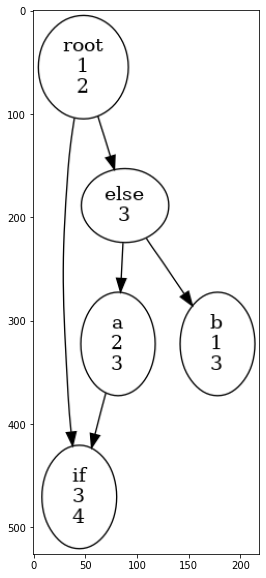

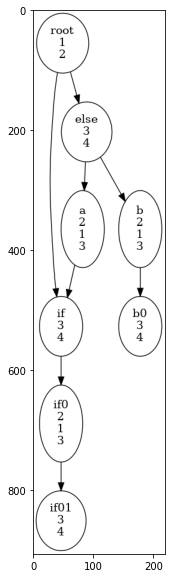

In [17]:
root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([3], "else")

a = NemesisNode([2,3], "a")
b = NemesisNode([1,3], "b")


G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch, a, b])
G.add_edges_from([(root, ifbranch), (root, elsebranch), (elsebranch, a), (elsebranch, b)])
G.add_edge(a, ifbranch)
to_png(G, "test_4_pre")
balance_branching_point(G,  root)
to_png(G, "test_4")



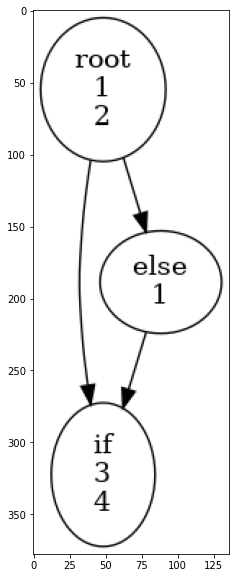

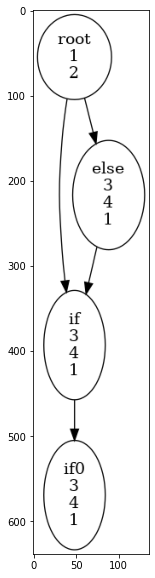

In [22]:
root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([1], "else")


G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch])
G.add_edges_from([(root, ifbranch), (root, elsebranch), (elsebranch, ifbranch)])

to_png(G, "test_5_pre")
balance_branching_point(G,  root)
to_png(G, "test_5")
